In [1]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
gc.enable()

In [2]:
df_core_snps = pd.read_csv("core_snps_filtered.csv", sep='\t')
df_core_snps.head(2)

,ref_rs_id,ref_chr,ref_bp,ref_af,ref_allele,ref_other_allele,ref_snp_num
0,rs7518469,1,4756276,0.94036,G,T,7518469
1,rs7521197,1,5758772,0.07654,C,T,7521197


In [3]:
df_eur = pd.read_csv("eur_tables/EUR_all_chr.ld", sep='\t')
df_british = pd.read_csv("eur_tables/British_all_chr.ld", sep='\t')
df_ceph = pd.read_csv("eur_tables/CEPH_all_chr.ld", sep='\t')
df_finnish = pd.read_csv("eur_tables/Finnish_all_chr.ld", sep='\t')
df_spanish = pd.read_csv("eur_tables/Spanish_all_chr.ld", sep='\t')
df_tuscan = pd.read_csv("eur_tables/Tuscan_all_chr.ld", sep='\t')
df_eur.head(2)

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R
0,1,4756276,rs7518469,0.059642,1,4515277,rs1213919,0.489066,-0.104870
1,1,4756276,rs7518469,0.059642,1,4522799,rs651713,0.346918,0.113732


In [4]:
df_british.shape

(1088934, 9)

In [8]:
df_dict = {'bri':df_british, 'ceph':df_ceph, 'fin':df_finnish, 'spa':df_spanish, 'tus':df_tuscan, 'eur':df_eur}
size_dict = {'bri':91, 'ceph':99, 'fin':99, 'spa':107, 'tus':107, 'eur':503}
nations = ['fin', 'spa', 'ceph', 'tus', 'bri', 'eur']
for name, df in df_dict.items():
    # incase we want to wilter out small r
    df.drop(df[abs(df["R"])<0.1].index,inplace=True)

In [9]:
df_british.shape

(1088934, 9)

In [10]:
merged_df = None
for name, df in df_dict.items():
    if merged_df is None:
        merged_df = df[['SNP_A', 'SNP_B', 'R']].copy()
        merged_df.rename(index=str, columns={"R": name}, inplace=True)
    else:
        df = df.rename(index=str, columns={"R": name}, inplace=False)
        merged_df = pd.merge(merged_df, df[['SNP_A', 'SNP_B', name]], how='inner', 
                       on=['SNP_A', 'SNP_B'])

In [40]:
print(merged_df.shape)
merged_df[['fin', 'spa', 'ceph', 'tus', 'bri','eur']] = abs(merged_df[['fin', 'spa', 'ceph', 'tus', 'bri', 'eur']])
#because I missed flag --keep-allele-order
merged_df.drop_duplicates(subset=['SNP_A', 'fin', 'spa', 'ceph', 'tus', 'bri'], inplace=True)
#because many SNPs are in 
print(merged_df.shape)
merged_df['average'] = np.mean(merged_df[['fin', 'spa', 'ceph', 'tus', 'bri']], axis=1)
merged_df.head(2)

(242562, 9)
(242562, 9)


,SNP_A,SNP_B,bri,eur,spa,ceph,tus,fin,average
0,rs7521197,rs707593,0.323846,0.214508,0.250302,0.113991,0.161228,0.222214,0.214316
1,rs7521197,rs770702,0.202395,0.145569,0.109402,0.151899,0.180416,0.103178,0.149458


In [41]:
def get_conf_interval(r, N=100, alpha=0.05):
    z = np.arctanh(r)
    SE = 1/np.sqrt(N-3)
    z_alpha_2 = abs(norm.ppf(alpha/2))
    lower_margin = np.tanh(z - SE * z_alpha_2)
    upper_margin = np.tanh(z + SE * z_alpha_2)
    return {"lower":lower_margin, "upper":upper_margin}

def get_conf_interval_for_diff(r1, r2, n1=200, n2=200, alpha=0.05):
    PE = r1 - r2
    SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
    z_alpha_2 = abs(norm.ppf(alpha/2))
    lower_margin = PE - SE * z_alpha_2
    upper_margin = PE + SE * z_alpha_2
    return {"lower":lower_margin, "upper":upper_margin}

def get_snp_pairs_in_range(lower_threshold, upper_threshold, nation):
    df_temp = merged_df[(abs(merged_df[nation]) > lower_threshold) & 
                        (abs(merged_df[nation]) < upper_threshold)].copy()
    df_temp = df_temp[~(df_temp==1).any(axis= 1)]
    df_temp.drop_duplicates(subset='SNP_A', inplace=True)
    return df_temp

def get_margin_r_for_diff(r1, n1=200, n2=200, alpha=0.05):
    z_alpha_2 = abs(norm.ppf(alpha/2))
    for r2 in np.linspace(r1,1,1000):
        PE = r1 - r2
        SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
        upper_margin = PE + SE * z_alpha_2
        if upper_margin < 0:
            r2_upper = r2
            break
    for r2 in np.linspace(r1,0,1000):
        PE = r1 - r2
        SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
        lower_margin = PE - SE * z_alpha_2
        if lower_margin > 0:
            r2_lower = r2
            break
    return {"r2_lower":r2_lower, "r2_upper":r2_upper}

737


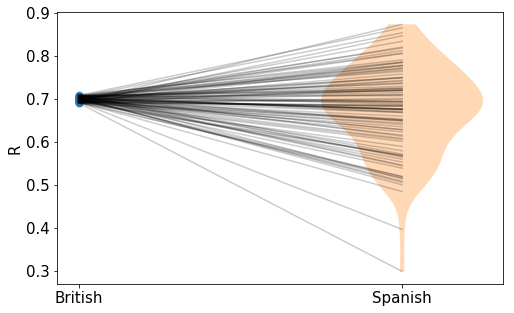

In [42]:
initial_r = 0.7
initial_margin = 0.01
df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation='bri')
print(len(df_temp))
fig, ax = plt.subplots(figsize=(8, 5))

df_temp = df_temp.sample(100)
parts = ax.violinplot(np.array(df_temp['spa']), [1], showmeans=False, showextrema=False, showmedians=False)
for pc in parts['bodies']:
    pc.set_facecolor('#ff7f0e')
# plotting the points
ax.scatter(np.zeros(len(df_temp)), df_temp.bri, s=50, alpha=0.1)
#ax.scatter(np.ones(len(df_temp)), df_temp.spa, s=500, alpha=0.1)

# plotting the lines
for index, row in df_temp.iterrows():
    ax.plot( [0,1], [row.bri, row.spa], c='k', alpha=0.2)

#ax.set_xticklabels( () )
ax.set_xticks([0,1])
ax.set_xticklabels(['British', 'Spanish'])
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.set_ylabel('R')
plt.savefig('British-Spanish.png', dpi=300)
plt.show()
plt.close()

#print("Variance \n", df_temp[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']].var())
#print("mean \n", df_temp[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']].mean())

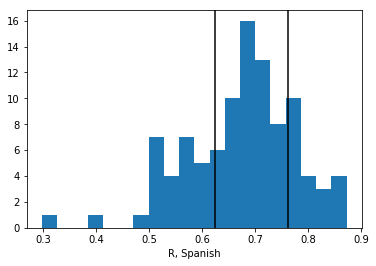

In [43]:
spanish_CI = get_conf_interval(initial_r, N=107*2)

plt.hist(df_temp.spa, bins=20)
plt.axvline(x=spanish_CI['lower'], c = 'k')
plt.axvline(x=spanish_CI['upper'], c = 'k')
plt.xlabel('R, Spanish')
plt.show()

In [44]:
print(spanish_CI)

{'upper': 0.76252911469958629, 'lower': 0.62451378613348041}


In [45]:
print('Percentage of SNP pairs inside CI')
print(sum((df_temp.spa > spanish_CI['lower']) & (df_temp.spa < spanish_CI['upper']) )/len(df_temp)*100)

Percentage of SNP pairs inside CI
51.0


In [46]:
res = get_conf_interval_for_diff(df_temp.bri, df_temp.spa, n1=size_dict['bri']*2, n2=size_dict['spa']*2)
print(sum(res['lower']>0)/len(df_temp)*100)
print(sum(res['upper']<0)/len(df_temp)*100)
print(sum(res['lower']>0)/len(df_temp)*100 + sum(res['upper']<0)/len(df_temp)*100)

21.0
11.0
32.0


In [47]:
def get_percentage_of_pairs_diff_is_significant(real_pop, ref_pop, initial_r, initial_margin=initial_margin):
    df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation=real_pop)
    res = get_conf_interval_for_diff(r1=df_temp[real_pop], r2=df_temp[ref_pop], 
                                     n1=size_dict[real_pop]*2, n2=size_dict[ref_pop]*2)
    return(sum(res['lower']>0)/len(df_temp)*100 + sum(res['upper']<0)/len(df_temp)*100)
    
    

In [48]:
get_percentage_of_pairs_diff_is_significant('bri', 'spa', 0.85,0.1)

49.63963963963964

In [49]:
delta_margin = get_margin_r_for_diff(initial_r, n1=size_dict['bri']*2, n2=size_dict['spa']*2, alpha=0.05)
print(delta_margin)
print(sum((df_temp.spa > delta_margin['r2_lower']) & (df_temp.spa < delta_margin['r2_upper']) )/len(df_temp.spa)*100)

{'r2_lower': 0.58438438438438434, 'r2_upper': 0.78978978978978975}
68.0


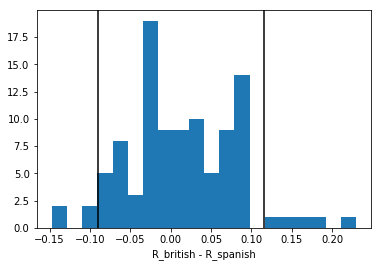

In [50]:
plt.hist(df_temp.bri - df_temp.eur , bins=20)
plt.xlabel('R_british - R_spanish')
plt.axvline(x=initial_r - delta_margin['r2_upper'], c = 'k')
plt.axvline(x=initial_r - delta_margin['r2_lower'], c = 'k')
plt.show()

# Delta-R from R


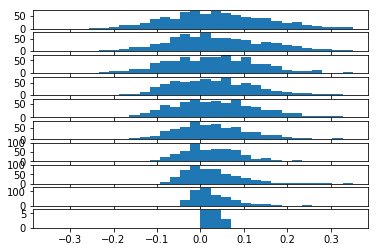

([0.59999999999999998,
  0.64444444444444438,
  0.68888888888888888,
  0.73333333333333328,
  0.77777777777777779,
  0.82222222222222219,
  0.8666666666666667,
  0.91111111111111109,
  0.95555555555555549,
  1.0],
 [0.015171612463174769,
  0.013639051523252524,
  0.011928313871645523,
  0.010309978326566424,
  0.0092784908355446824,
  0.0078998940642675455,
  0.0054741582784425119,
  0.0041790788490064425,
  0.002459939302670652,
  0.00032898199612380925])

In [51]:
def get_varr_r_lists(real_pop, ref_pop, initial_r=0.6, number_of_plots=10, plot_hist=False):
    r_array = []
    var_array = []
    for index, initial_r in enumerate(np.linspace(0.6,1,number_of_plots)):
        df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation=real_pop)
        delta_r = df_temp[real_pop] - df_temp[ref_pop]
        r_array.append(initial_r)
        var_array.append(delta_r.var())
        if plot_hist:    
            plt.subplot(number_of_plots, 1, index+1)
            plt.hist(delta_r, bins=30,  range=(-0.35, 0.35))
    if plot_hist:    
        plt.show()
    return r_array, var_array

get_varr_r_lists(real_pop = 'bri', ref_pop='spa', plot_hist=True)
    

In [52]:
df = pd.read_hdf('../LD_simul/results/r_0.75_0.85_0.95.h5')

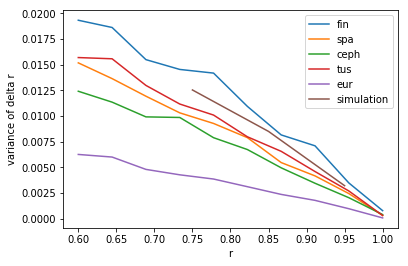

In [56]:
for nation in ['fin', 'spa', 'ceph', 'tus', 'eur']:
    r_array, var_array = get_varr_r_lists(real_pop = 'bri', ref_pop=nation)
    plt.plot(r_array, var_array, label=nation)
    
plt.plot( df[df.gen == 300].groupby('r_0')['r'].var(), label = 'simulation' )

    
plt.xlabel('r')
plt.ylabel('variance of delta r')
plt.legend()
plt.show()    



##  Cojo info

In [25]:
cojo_df = pd.read_csv('first_type_error.tsv', sep = '\t')
cojo_df = cojo_df.round({'delta_r':3})
cojo_df.head(2)
print(cojo_df.sim_r.unique())

[ 0.3  0.4  0.5  0.6  0.7]


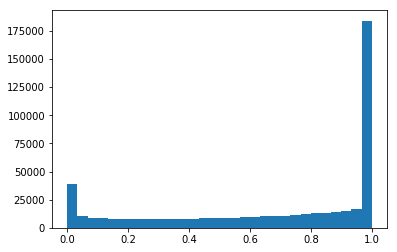

In [26]:
plt.hist(cojo_df.sort_values('joint_p').joint_p, bins=30)
plt.show()

In [27]:
def first_type_error_rate(sim_r):
    # delta_r = real - reference
    # delta_r < real + 1
    # delta_r > real - 1 
    fixed_sim_r_df = cojo_df[(cojo_df.sim_r == sim_r)]
    delta_r_array = cojo_df[(cojo_df.sim_r == sim_r) & 
                            (cojo_df.delta_r > sim_r - 1) & 
                            (cojo_df.delta_r < sim_r + 1)].delta_r.unique()
    fdr_list = []
    delta_r_list = []

    for delta_r in delta_r_array:
        temp_df = fixed_sim_r_df[(fixed_sim_r_df.delta_r == delta_r)]
        fdr = len(temp_df[temp_df.joint_p < 0.05])/len(temp_df)
        if len(temp_df) > 100:
            fdr_list.append(fdr)
            delta_r_list.append(delta_r)
            #print(len(temp_df), delta_r)
    return( pd.DataFrame({'delta_r': delta_r_list, 'fdr': fdr_list}))

In [28]:
def get_crical_values(sim_r):
    fdr_dynamics = first_type_error_rate(sim_r)
    min_r = sim_r - fdr_dynamics[fdr_dynamics.fdr < 0.10].delta_r.max()
    max_r = sim_r - fdr_dynamics[fdr_dynamics.fdr < 0.10].delta_r.min()
    return min_r, max_r

In [29]:
for i in cojo_df.sim_r.unique():
    lower, upper = get_crical_values(i)
    print(i, get_crical_values(i), i - upper, i - lower)

0.3 (-0.36700000000000005, 0.60299999999999998) -0.303 0.667
0.4 (-0.22599999999999998, 0.622) -0.222 0.626
0.5 (-0.247, 0.68199999999999994) -0.182 0.747
0.6 (-0.22799999999999998, 0.74099999999999999) -0.141 0.828
0.7 (-0.249, 0.80099999999999993) -0.101 0.949


[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90.]


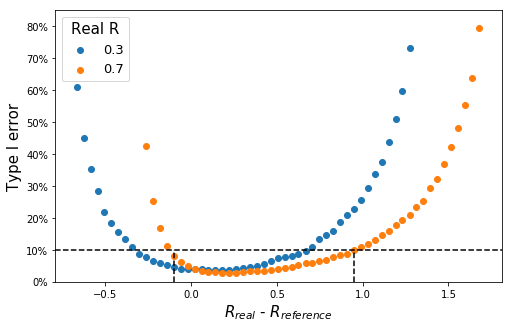

In [30]:
lower, upper = get_crical_values(0.7)
fig, ax = plt.subplots(figsize=(8, 5))
for i in [0.3, 0.7]:
    fdr_dynamics = first_type_error_rate(i)
    #print(fdr_dynamics[(fdr_dynamics.delta_r <= 0.0) & (fdr_dynamics.delta_r >= -0.5)])
    ax.scatter(fdr_dynamics.delta_r, fdr_dynamics.fdr*100, label = i)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

#ax.legend(title = 'Real R',loc='upper left', fontsize = 15)
legend = ax.legend(title = 'Real R',loc='upper left', fontsize = 13)
plt.setp(legend.get_title(),fontsize='15')
ax.set_xlabel('$R_{real}$ - $R_{reference}$')
ax.set_ylabel('Type I error')
y_max = 0.85
ax.set_ylim(0, y_max*100)
print(ax.get_yticks())
ax.set_yticklabels([str(int(i))+'%' for i in ax.get_yticks()])

ax.axhline(y=10, c = 'k', linestyle='--')
ax.axvline(x=0.7 - lower, ymin=0.0, ymax = 0.1/y_max, color='k', linestyle='--')
ax.axvline(x=0.7 -upper, ymin=0.0, ymax = 0.1/y_max, color='k', linestyle='--')

plt.savefig('FDR.png', dpi=300)
plt.show()

plt.close()

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90.]


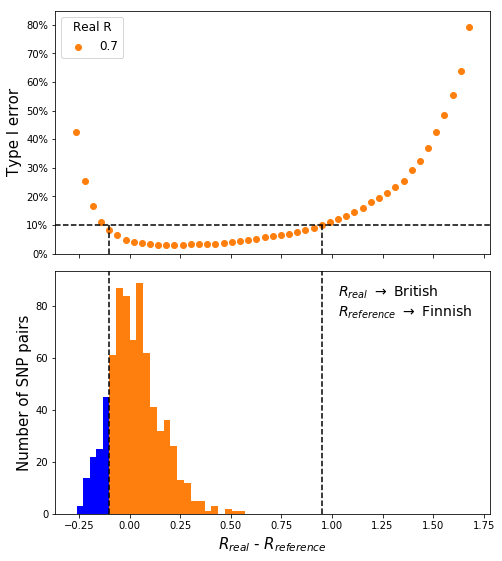

In [79]:
plt.close()

lower, upper = get_crical_values(0.7)
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(7, 9))
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(left = 0.1)

for i in [0.7]:
    fdr_dynamics = first_type_error_rate(i)
    ax.scatter(fdr_dynamics.delta_r, fdr_dynamics.fdr*100, label = i, color='#ff7f0e')
ax2.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax2.yaxis.label.set_fontsize(15)


#ax.legend(title = 'Real R',loc='upper left', fontsize = 15)
legend = ax.legend(title = 'Real R',loc='upper left', fontsize = 12)
plt.setp(legend.get_title(),fontsize='12')
ax2.set_xlabel('$R_{real}$ - $R_{reference}$')
ax.set_ylabel('Type I error')
y_max = 0.85
ax.set_ylim(0, y_max*100)
print(ax.get_yticks())
ax.set_yticklabels([str(int(i))+'%' for i in ax.get_yticks()])
#ax.set_xlim(-2, 2)
ax.axhline(y=10, c = 'k', linestyle='--')
ax.axvline(x=0.7 - lower, ymin=0.0, ymax = 0.1/y_max, color='k', linestyle='--')
ax.axvline(x=0.7 -upper, ymin=0.0, ymax = 0.1/y_max, color='k', linestyle='--')
df_temp = get_snp_pairs_in_range(lower_threshold=0.69,
                                 upper_threshold=0.71, 
                                 nation='bri')
for_hist = df_temp.bri - df_temp.fin
ax2.hist( for_hist[for_hist> 0.7 -upper], bins=20, color='#ff7f0e')
ax2.hist( for_hist[for_hist< 0.7 -upper], bins=5, color='b')
#ax2.legend( "$R_{real}$ - British, $R_{reference} - Finnish$",loc='upper left', fontsize = 12)
ax2.text(0.65, 0.95, r"$R_{real}$ $\rightarrow$ British" + '\n' + r"$R_{reference}$ $\rightarrow$ Finnish", transform=ax2.transAxes, fontsize=14,
        verticalalignment='top')
#ax2.axhline(y=10, c = 'k', linestyle='--')
ax2.axvline(x=0.7 - lower, color='k', linestyle='--')
ax2.axvline(x=0.7 -upper, color='k', linestyle='--')
ax2.set_ylabel('Number of SNP pairs')
plt.savefig('FDR.png', dpi=300)
plt.show()
plt.close()

In [ ]:
def get_var_attributed_pop_diff(real_pop, ref_pop, initial_r, initial_margin=0.01,
                                                            sample_size_coefficient = 2):
    '''sample_size_coefficient - 
    How many chromosomes are used in LD calculations compared to initial number of individuals'''
    
    df_temp = get_snp_pairs_in_range(lower_threshold=initial_r-initial_margin,
                                 upper_threshold=initial_r+initial_margin, 
                                 nation=real_pop)
    
    
    # vector of r values for reference population is transformed into vercotr of z-scores
    z = np.arctanh(df_temp[ref_pop])

    # total variance of the sample from reference population
    total_variance = z.var()
    #print(total_variance)
    # How many chromosomes are used in LD calculations compared to initial number of individuals
    # variance explained from finite size of real (GWAS) population
    var_by_real_pop_sample = 1/(size_dict[real_pop]*sample_size_coefficient - 3)
    # variance explained from fineze size of reference popualtion 
    var_by_ref_pop_sample = 1/(size_dict[ref_pop]*sample_size_coefficient - 3)
    # variance attributed to difference between populations
    var_by_pop_dif = total_variance - var_by_real_pop_sample - var_by_ref_pop_sample
    
    return var_by_pop_dif


def get_perc_of_pairs_above_cojo_threshold_expl_by_pop_diff(real_pop, ref_pop, initial_r, initial_margin=0.01,
                                                            sample_size_coefficient = 2):
    # thresholds from cojo joint test simulations
    lower, upper = get_crical_values(initial_r)
    # upper threshold is transformed to z-threshold
    df_temp = get_snp_pairs_in_range(lower_threshold=initial_r-initial_margin,
                                 upper_threshold=initial_r+initial_margin, 
                                 nation=real_pop)
    percentage_of_bad_pairs = len(df_temp[df_temp[ref_pop] > upper])/len(df_temp)
    return percentage_of_bad_pairs*100

In [81]:
def get_var_attributed_pop_diff(real_pop, ref_pop, initial_r, initial_margin=0.01,
                                                            sample_size_coefficient = 2):
    '''sample_size_coefficient - 
    How many chromosomes are used in LD calculations compared to initial number of individuals'''
    
    df_temp = get_snp_pairs_in_range(lower_threshold=initial_r-initial_margin,
                                 upper_threshold=initial_r+initial_margin, 
                                 nation=real_pop)
    
    
    # vector of r values for reference population is transformed into vercotr of z-scores
    z = np.arctanh(df_temp[ref_pop])

    # total variance of the sample from reference population
    total_variance = z.var()
    #print(total_variance)
    # How many chromosomes are used in LD calculations compared to initial number of individuals
    # variance explained from finite size of real (GWAS) population
    var_by_real_pop_sample = 1/(size_dict[real_pop]*sample_size_coefficient - 3)
    # variance explained from fineze size of reference popualtion 
    var_by_ref_pop_sample = 1/(size_dict[ref_pop]*sample_size_coefficient - 3)
    # variance attributed to difference between populations
    var_by_pop_dif = total_variance - var_by_real_pop_sample - var_by_ref_pop_sample
    
    return var_by_pop_dif


def get_perc_of_pairs_above_cojo_threshold_expl_by_pop_diff(real_pop, ref_pop, initial_r, initial_margin=0.01,
                                                            sample_size_coefficient = 2):
    # thresholds from cojo joint test simulations
    lower, upper = get_crical_values(initial_r)
    # upper threshold is transformed to z-threshold
    z_limit = np.arctanh(upper)
    var_by_pop_dif = get_var_attributed_pop_diff(real_pop, ref_pop, initial_r, initial_margin=0.01,
                                                            sample_size_coefficient = 2)
    SE = np.sqrt(var_by_pop_dif)
    z_value = (z_limit - np.arctanh(initial_r))/SE
    p_value = norm.cdf(-z_value)
    return p_value*100

In [83]:
res = pd.DataFrame({'r': cojo_df.sim_r.unique()})
for nation in ['fin', 'spa', 'ceph', 'tus','eur']:
    nation_col = []
    for r in cojo_df.sim_r.unique():
        nation_col.append(get_perc_of_pairs_above_cojo_threshold_expl_by_pop_diff(
            real_pop='bri', ref_pop=nation, initial_r=r))
    res[nation] = nation_col
res

/home/sega/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


,r,fin,spa,ceph,tus,eur
0,0.3,0.005826,3.574344e-07,1.043563e-07,7.259719e-08,NaN
1,0.4,0.858659,1.140474e-01,5.623340e-02,1.477546e-01,3.788437e-11
2,0.5,3.871047,1.320927e+00,1.010730e+00,1.414542e+00,1.972028e-03
3,0.6,9.403140,4.683475e+00,2.999468e+00,4.894737e+00,1.463173e-01
4,0.7,15.448774,9.043803e+00,6.722123e+00,9.544780e+00,1.071511e+00


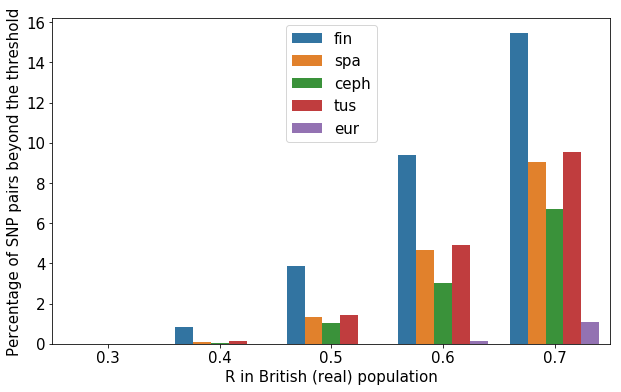

In [84]:
import seaborn as sns
data = pd.melt(res,id_vars=['r'], value_vars=['fin', 'spa', 'ceph', 'tus','eur'], value_name='FDR', var_name='ref nation')
plt.figure(figsize=(10,6))
ax = sns.barplot(x='r', y='FDR', hue='ref nation', data = data)
ax.set(xlabel='R in British (real) population', ylabel='Percentage of SNP pairs beyond the threshold')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.legend(fontsize = 15)
plt.savefig('test.png', dpi=300)
plt.show()


0.673727210312
0.146540027137
0.146540027137
0.176752206646


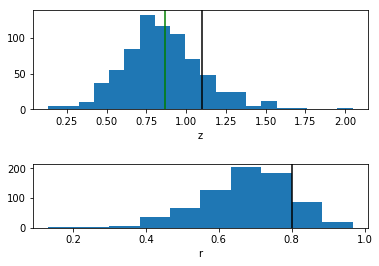

In [98]:
initial_r = 0.7
initial_margin = 0.01
df_temp = get_snp_pairs_in_range(lower_threshold=initial_r-initial_margin,
                                 upper_threshold=initial_r+initial_margin, 
                                 nation='bri')
lower, upper = get_crical_values(initial_r)

r_disrt = df_temp.fin
z_distr = np.arctanh(r_disrt)
z_limit = np.arctanh(upper)

print(np.mean(r_disrt))
print(sum(r_disrt>upper)/len(r_disrt))
print(sum(z_distr>z_limit)/len(z_distr))
total_variance = z_distr.var()
var_by_pop_dif = total_variance - 1/200*2
SE = np.sqrt(total_variance)
z_value = (z_limit - np.arctanh(initial_r))/SE
p_value = norm.cdf(-z_value)
print(p_value)

plt.subplot(2, 1, 1)
plt.hist(z_distr, bins=20) 
plt.xlabel('z')
plt.axvline(x=z_limit, c = 'k')
plt.axvline(x=np.arctanh(initial_r), c = 'g')

plt.subplot(3, 1, 3)
plt.hist(r_disrt)
plt.axvline(x=upper, c = 'k')
plt.xlabel('r')
plt.show()


In [93]:
np.arctanh(initial_r)

0.86730052769405308

# Stuff

In [ ]:
df_eur['dist'] = abs(df_eur['BP_A'] - df_eur['BP_B'])

In [ ]:
plt.scatter(df_eur['dist'], abs(df_eur['R']), alpha=0.01, s=0.7)
plt.xlabel("distance from core SNP")
plt.ylabel("abs(r)")
plt.show()

In [ ]:
df_08 = get_snp_pairs_in_range(lower_threshold=0.79, upper_threshold=0.81, nation='average')
abs(df_08[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_08[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).std())

In [ ]:
df_07 = get_snp_pairs_in_range(lower_threshold=0.69, upper_threshold=0.71, nation='average')
abs(df_07[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_07[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).std())

# Fisher Z-transformation

In [ ]:
get_conf_interval(0.7, N=91*2)

In [ ]:
get_conf_interval(0.7, N=107*2)

In [ ]:
ci = get_conf_interval(0.8, N=100)
print(ci)
for name in df_dict.keys():
    print( name, len(df_08[(abs(df_08[name]) > ci["lower"]) & (abs(df_08[name]) < ci["upper"])])/len(df_08))